<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD;
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" height="50px"> <a href='https://harvard-iacs.github.io/2023-AC215/' target='_blank'><strong><font color="#A41034">AC215: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#A41034">Tutorial - Mushroom Classification Models, Experiment Tracking</font>**

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**<br/>
Pavlos Protopapas

<hr style="height:2pt">

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Installs**

In [1]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00


**Imports**

In [35]:
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 39.9 MB/s eta 0:00:00


In [36]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
import tensorflow_io as tfio

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

from IPython.display import Audio, display

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [3]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.13.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [4]:
!nvidia-smi

Sat Oct  7 21:13:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |    361MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [5]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0],
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })

  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

## **<font color="#A41034">Dataset</font>**

#### **Download**

In [6]:
import os
import subprocess

# Define the GitHub repository URL
github_repo_url = "https://github.com/gveres/donateacry-corpus.git"

# Clone the repository
subprocess.run(["git", "clone", github_repo_url])

# Define the path to the cloned repository
repo_path = "donateacry-corpus"

# Initialize empty lists to store WAV file paths and folder names
wav_files = []
folder_names = []

# Walk through the directory structure to find WAV files and their folders
for root, dirs, files in os.walk(repo_path):
    for file in files:
        if file.endswith(".wav"):
            # Get the full path of the WAV file
            wav_path = os.path.join(root, file)

            # Extract the folder name from the path
            folder_name = os.path.basename(root)

            # Append the WAV file path and folder name to the respective lists
            wav_files.append(wav_path)
            folder_names.append(folder_name)

In [7]:
wav_files[0:5], folder_names[0:5]

(['donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138495-1.0-m-72-bp.wav',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138506-1.0-m-72-bp.wav',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138545-1.0-m-72-bp.wav',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/999bf14b-e417-4b44-b746-9253f81efe38-1430974001343-1.7-m-26-bp.wav'],
 ['belly_pain', 'belly_pain', 'belly_pain', 'belly_pain', 'belly_pain'])

In [8]:
folder_names.count("discomfort"), folder_names.count("belly_pain"), folder_names.count("hungry"), folder_names.count("tired"), folder_names.count("burping")

(27, 16, 382, 24, 8)

### **Load Data**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

### **View Images**

Let's take a look at the data.

In [9]:
my_data_list = list(zip(folder_names, wav_files))
my_data_list[0:5]

[('belly_pain',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138495-1.0-m-72-bp.wav'),
 ('belly_pain',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138506-1.0-m-72-bp.wav'),
 ('belly_pain',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138545-1.0-m-72-bp.wav'),
 ('belly_pain',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav'),
 ('belly_pain',
  'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/999bf14b-e417-4b44-b746-9253f81efe38-1430974001343-1.7-m-26-bp.wav')]

In [10]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random


In [11]:
def wav_to_spectrogram(file_path, output_shape=(128, 64)):
    # Load the WAV file
    y, sr = librosa.load(file_path, sr=8000, dtype=np.float32)
    # print(sr)

    # Generate the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    # Resize the spectrogram so that it can be fed into the model
    spectrogram = librosa.util.fix_length(spectrogram, size=output_shape[1], mode='constant', constant_values=0)

    # Normalize the spectrogram to values between 0 and 1, this really helps improve model accuracy
    spectrogram = librosa.util.normalize(spectrogram)

    return spectrogram, sr, y

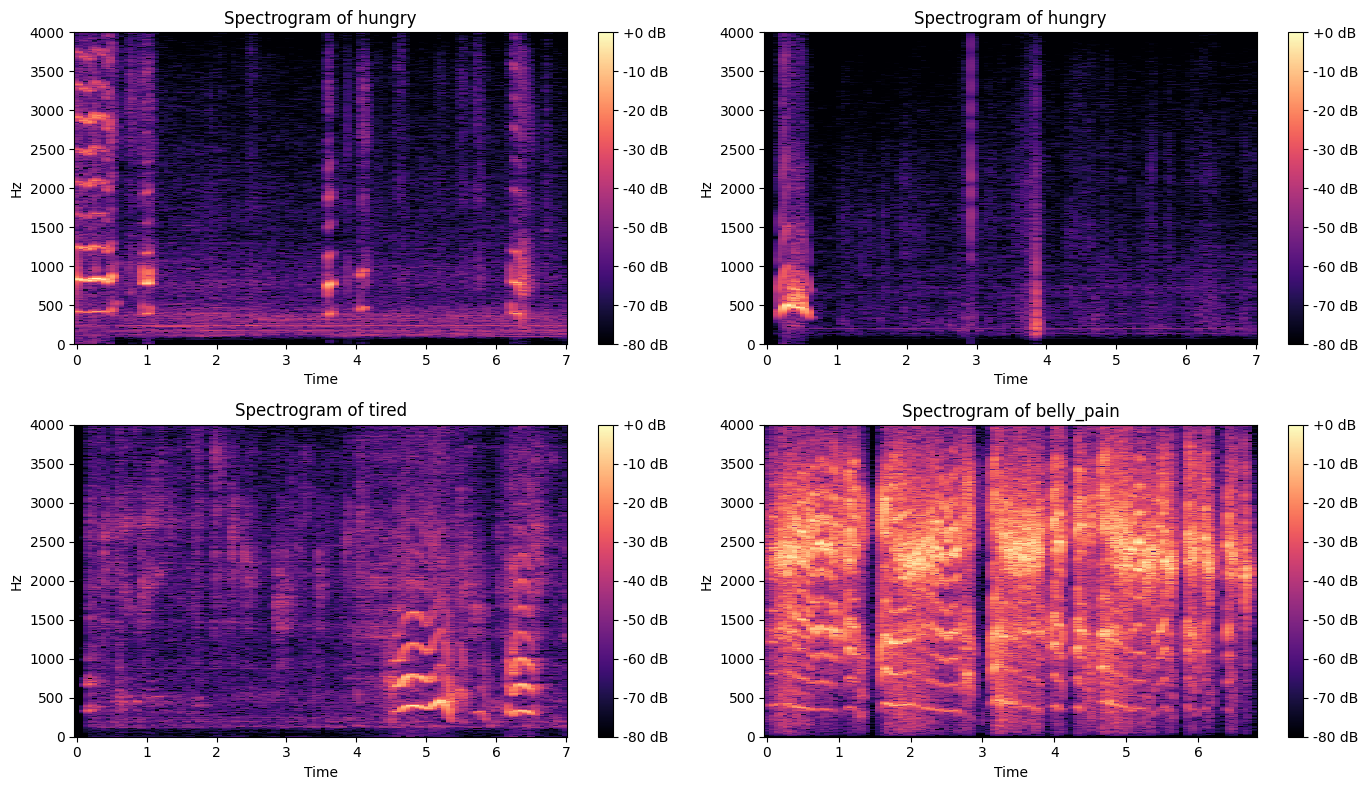

In [12]:
def display_random_spectrograms_with_audio(data_list, num_rows=5, num_cols=2):
    # Shuffle the data list randomly
    random.shuffle(data_list)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))

    for i in range(num_rows):
        for j in range(num_cols):
            # Get the next data point from the shuffled list
            if data_list:
                label, file_path = data_list.pop()

                # Load the WAV file and generate the spectrogram
                spectrogram, sr, y = wav_to_spectrogram(file_path)

                # Display the spectrogram on the current subplot
                D = librosa.stft(y)
                S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
                ax = axes[i, j]
                img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr=sr)
                fig.colorbar(img, ax=ax, format="%+2.f dB")

                # Set the title of the subplot to the label
                ax.set(title=f'Spectrogram of {label}')

                # Create an audio widget for playback
                audio_widget = Audio(y, rate=sr)

                # Display the audio widget next to the spectrogram
                display(audio_widget)

    plt.tight_layout()
    plt.show()

# Example usage:
display_random_spectrograms_with_audio(my_data_list, num_rows=2, num_cols=2)

## **<font color="#A41034">Build Data Pipelines</font>**

### **Load X & Y**

Generate data_x and data_y

In [13]:
# Build data x, y
data_x = [itm[1] for itm in my_data_list]
data_y = [itm[0] for itm in my_data_list]

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_x: 453
data_y: 453
data_x: ['donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/hungry/aaa57dbd-7b88-454a-963e-6faa2f4ed4e7-1436982098411-1.7-f-04-hu.wav', 'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/hungry/F4A0C710-AC2D-42E0-8EA9-3E4CAC31EE20-1430318416-1.0-m-04-hu.wav', 'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/discomfort/64acb345-a61e-4ef3-a5a6-cf83c04b83f1-1430059012473-1.7-m-72-dc.wav', 'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/hungry/9aa8bac5-eeb9-4f19-a4bf-7c439e87364b-1430745385374-1.7-m-04-hu.wav', 'donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain/C421C6FE-DFEE-4080-8AEA-848E7CE4756B-1430548333-1.0-f-26-bp.wav']
data_y: ['hungry', 'hungry', 'discomfort', 'hungry', 'belly_pain']


### **Split Data**
We split data into test, validation, & train

In [14]:
test_percent = 0.10
validation_percent = 0.2

# Need to stratify because of our highly imbalanced dataset
# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent, stratify=data_y)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent, stratify=train_validate_y)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 366
validate_x count: 41
test_x count: 46


### **Create TF Datasets**

In [72]:
import tensorflow as tf
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# num_channels = 1 because the wav files are mono, like if you wore a headset you'd hear the same audio from both the left and right
def get_audio_dataset(sampling_rate, num_classes, num_channels=1, batch_size=32):
    # # Load Audio
    # def load_audio(path, label):
    #     audio = tf.io.read_file(path)
    #     # trying something different from the wav_to_spectrogram function
    #     audio, _ = tf.audio.decode_wav(audio, desired_channels=num_channels)
    #     audio = tf.squeeze(audio, axis=-1)  # Remove extra channel if stereo
    #     audio = tfio.audio.resample(audio, sampling_rate, sampling_rate) #TO DO, currently all of our sampling rate is the same at 8k
    #     return audio, label

    def wav_to_spectrogram_and_label(file_path, label):
      spectrogram, sr, y = wav_to_spectrogram(file_path)
      return spectrogram, label

    # Convert labels to numbers using LabelEncoder
    label_encoder = LabelEncoder()
    train_y_encoded = label_encoder.fit_transform(train_y)
    validate_y_encoded = label_encoder.transform(validate_y)
    test_y_encoded = label_encoder.transform(test_y)

    # Apply one-hot encoding to labels
    onehot_encoder = OneHotEncoder(sparse=False)
    train_y_onehot = onehot_encoder.fit_transform(train_y_encoded.reshape(-1, 1))
    validate_y_onehot = onehot_encoder.transform(validate_y_encoded.reshape(-1, 1))
    test_y_onehot = onehot_encoder.transform(test_y_encoded.reshape(-1, 1))

    train_shuffle_buffer_size = len(train_x)
    validation_shuffle_buffer_size = len(validate_x)

    # Create TF Dataset
    train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y_onehot))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_y_onehot))
    test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y_onehot))

    #############
    # Train data
    #############
    # Apply all data processing logic
    train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
    # train_data = train_data.map(load_audio, num_parallel_calls=tf.data.AUTOTUNE)
    train_data = train_data.map(wav_to_spectrogram_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    train_data = train_data.batch(batch_size)
    train_data = train_data.prefetch(tf.data.AUTOTUNE)

    ##################
    # Validation data
    ##################
    # Apply all data processing logic
    validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
    # validation_data = validation_data.map(load_audio, num_parallel_calls=tf.data.AUTOTUNE)
    validation_data = validation_data.map(wav_to_spectrogram_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    validation_data = validation_data.batch(batch_size)
    validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

    ############
    # Test data
    ############
    # Apply all data processing logic
    # test_data = test_data.map(load_audio, num_parallel_calls=tf.data.AUTOTUNE)
    test_data = test_data.map(wav_to_spectrogram_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    test_data = test_data.batch(batch_size)
    test_data = test_data.prefetch(tf.data.AUTOTUNE)

    ##########
    # Ensure same size train? #
    ##########

    # Assuming train_data is your training dataset
    num_samples = len(train_data)
    num_batches = num_samples // batch_size  # Calculate the number of full batches

    # Create a new dataset with only full batches
    train_data = train_data.take(num_batches * batch_size)

    return train_data, validation_data, test_data


In [24]:
# Function to convert labels back to original form
def decode_labels(encoded_labels):
    decoded_labels = label_encoder.inverse_transform(np.argmax(encoded_labels, axis=1))
    return decoded_labels

## **<font color="#A41034">Image Classificaton Models</font>**

### **Experiment Tracking**

Login to WandB to keep track of models. If you do not have an account signup in [WandB](https://wandb.ai/) to create a account for model tracking

In [16]:
# Login to W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
# Let's not train the base since our dataset is quite small

In [45]:
input_shape = (128, 64, 1) # spectrogram shape, 1 channel for mono
num_classes = 5

In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_audio_vgg_model(input_shape, num_classes, model_name):
    model = models.Sequential(name=model_name)

    # First convolution block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Second convolution block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Third convolution block
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Fourth convolution block
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Fifth convolution block
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [61]:
def build_audio_resnet_model(input_shape, num_classes, model_name):
    # I heard imagenet could still be useful for audio data? Let's just use it since we have limited data
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    model = models.Sequential(name=model_name)

    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [73]:
############################
# Training VGG
############################
model_name = "vgg"
learning_rate = 0.001
batch_size = 32
epochs = 15

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_audio_dataset(sampling_rate = 8000
                                                         , num_classes = num_classes
                                                         , num_channels=1
                                                         , batch_size=32)

# Model
model = build_audio_vgg_model(input_shape = input_shape
                              , num_classes = num_classes
                              , model_name = model_name)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'],
                  run_eagerly=True)

# Initialize a W&B run
wandb.init(
    project = 'crycrybaby',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    # name = "vgg1"
    )

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        #callbacks = [WandbMetricsLogger(log_freq=1)],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


TypeError: ignored

In [68]:
train_data.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [70]:
## Something is wrong, let's take a check

# Everything looks good here

print("Number of training samples:", len(train_x))
print("Number of validation samples:", len(validate_x))
print("Number of test samples:", len(test_x))
print("Example training sample path:", train_x[0])  # Check a sample path


Number of training samples: 366
Number of validation samples: 41
Number of test samples: 46
Example training sample path: donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/hungry/1309B82C-F146-46F0-A723-45345AFA6EA8-1430059849-1.0-f-04-hu.wav


In [71]:
spectrogram, sr, y = wav_to_spectrogram('donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/hungry/1309B82C-F146-46F0-A723-45345AFA6EA8-1430059849-1.0-f-04-hu.wav')  # Example for one audio file
print("Spectrogram shape:", spectrogram.shape)


Spectrogram shape: (128, 64)


In [ ]:
############################
# Training ResNet
############################
model_name = "resnet"
learning_rate = 0.001
batch_size = 32
epochs = 15

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_audio_dataset(sampling_rate = 8000
                                                         , num_classes = num_classes
                                                         , num_channels=1
                                                         , batch_size=32)

# Model
model = build_audio_resnet_model(input_shape = input_shape
                              , num_classes = num_classes
                              , model_name = model_name)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Initialize a W&B run
wandb.init(
    project = 'crycrybaby',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model.name
    },
    name = model.name
)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        #callbacks = [WandbMetricsLogger(log_freq=1)],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

## **<font color="#A41034">View Experiments in WandB App</font>**

Go to [WandB](https://wandb.ai/home) to view results

## **<font color="#A41034">Download Model from WandB</font>**

In [ ]:
# W&B Usage API
run = wandb.init()
artifact = run.use_artifact('ac215/mushroom-app-demo/model-mobilenetv2_train_base_True:v14', type='model')
artifact_dir = artifact.download()

wandb:   5 of 5 files downloaded.  


In [ ]:
print("artifact_dir",artifact_dir)
# Load a model from artifact dir
prediction_model = tf.keras.models.load_model(artifact_dir)

prediction_model.summary()

artifact_dir ./artifacts/model-mobilenetv2_train_base_True:v14
Model: "mobilenetv2_train_base_True"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 2388227 (9.11 MB)
Non-trainable params: 34112 (133.25 KB)


### **Predict using model**

1/1 [==============================] - 1s 1s/step
predictions.shape: (12, 3)
[0.0222698  0.03003092 0.9476993 ] 2


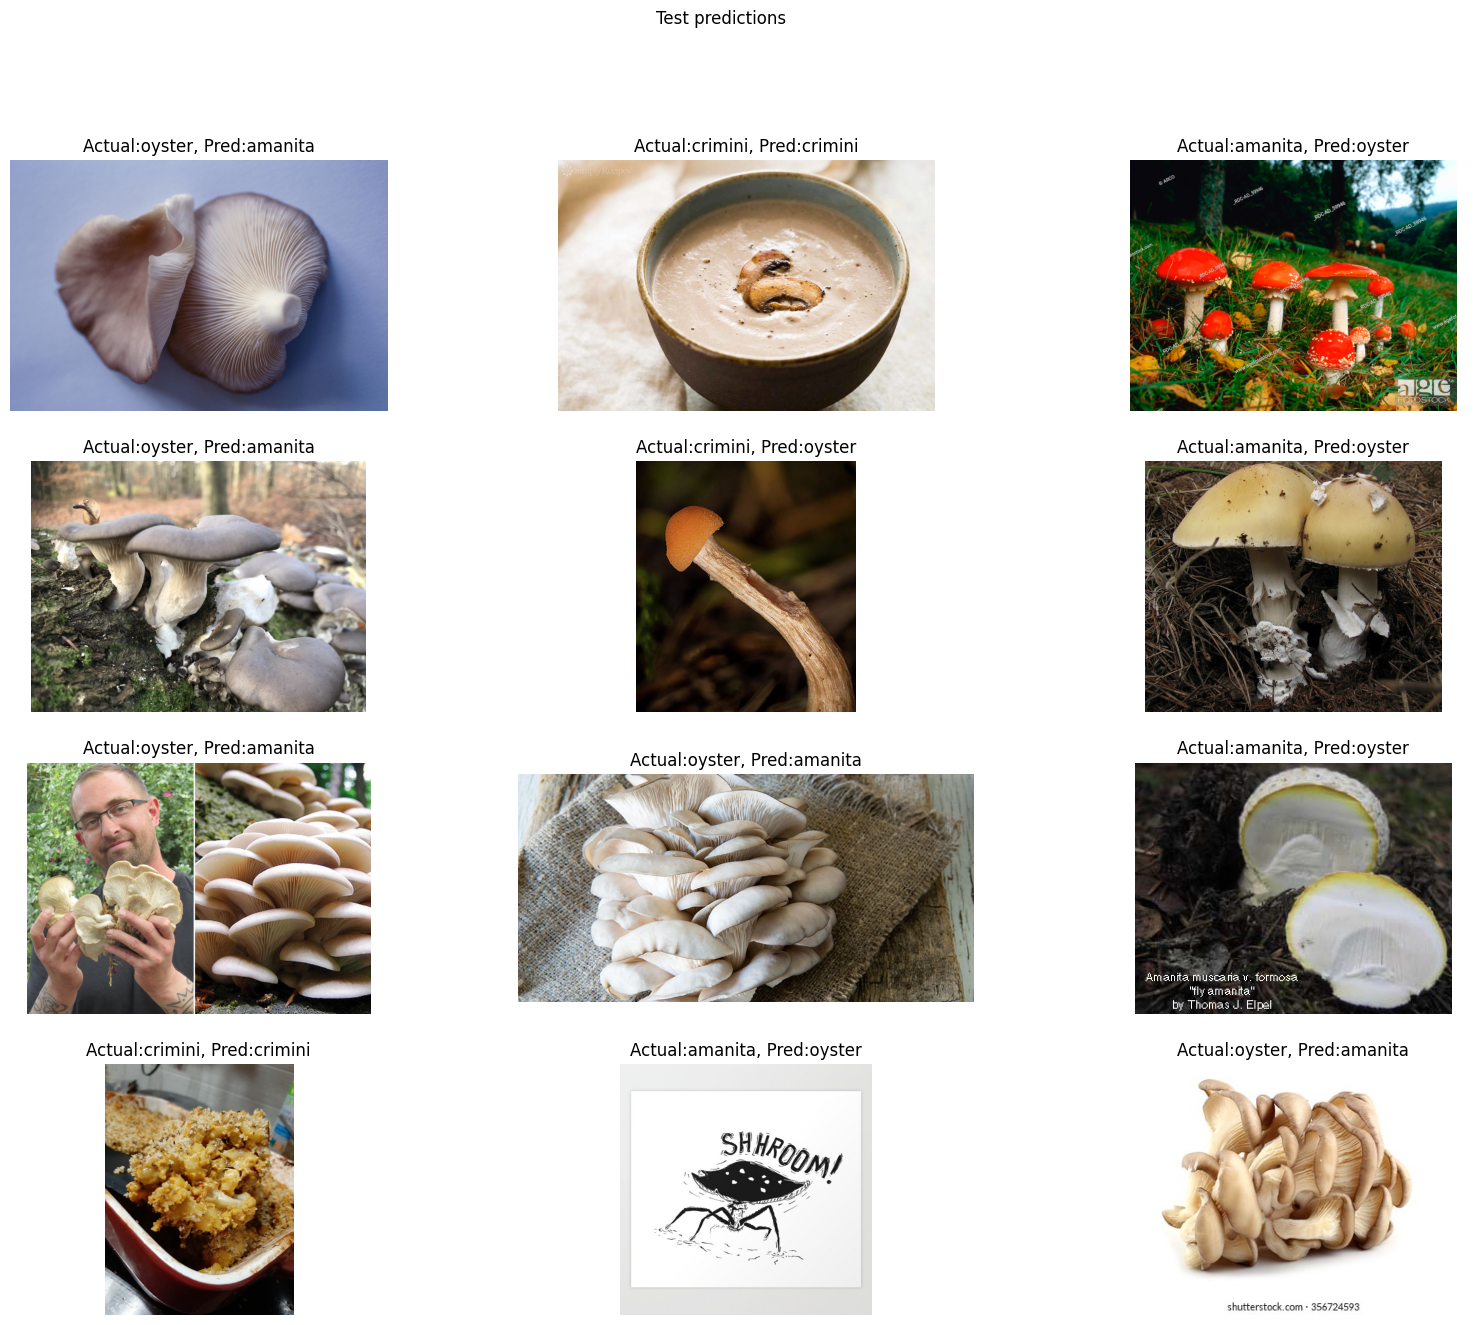

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(test_x)-1, size=12)
image_width = 224
image_height = 224
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]
# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = prediction_model.predict(prediction_data)
print("predictions.shape:",predictions.shape)
print(predictions[0],predictions[0].argmax())

fig = plt.figure(figsize=(20,15))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4,3,i+1)

    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # Actual label vs prediction
    prediction_label = index2label[predictions[i].argmax()]
    axs.set_title("Actual:"+test_y[img_idx]+", Pred:"+prediction_label)


    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()